In [3]:
from matplotlib import pyplot as plt
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

Double check that the user function (that provides the data points) returns the appropriate format.

Here, User function (that we want to estimate) should return 2d array or a tuple of 2d arrays 

In [3]:
from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

f, _ = branin_function() # or branin()

def branin(x, noise_level=0.):
    return np.reshape(_branin(x) + noise_level * np.random.randn(), (-1,1))

In [5]:
from scse.api.simulation import run_simulation

def f(X):
    Y = []
    for x in X:
        num_batteries = x[0]

        cum_reward = run_simulation(time_horizon=336, num_batteries=num_batteries)

        Y.append(cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

Initial design / data points

In [6]:
max_num_batteries = 25
num_batteries = DiscreteParameter('num_batteries', [i for i in range(0, max_num_batteries)])
week = 336
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, 52*week, week)])

parameter_space = ParameterSpace([num_batteries])
design = RandomDesign(parameter_space)

num_data_points = 4
X = design.get_samples(num_data_points)
X


array([[ 7],
       [18],
       [ 0],
       [ 5]])

In [7]:
Y = f(X)

In [18]:
Y

array([[-1354980],
       [-1052525],
       [-1666825],
       [-1435560]])

In [31]:
shape = (100, 1)
X0 = np.random.randint(-5, 10, shape)
X1 = np.random.randint(0, 15, shape)
X = np.concatenate((X0, X1), axis=1)
Y = np.reshape(np.append([], [branin(x) for x in X]), (-1, 1))

# or use RandomDesign
parameter_space = ParameterSpace([ContinuousParameter(
    'x1', -5, 10), ContinuousParameter('x2', 0, 15)])
design = RandomDesign(parameter_space)
if not X:
    num_data_points = shape[0]
    X = design.get_samples(num_data_points)

Plotting initial design values (branin)

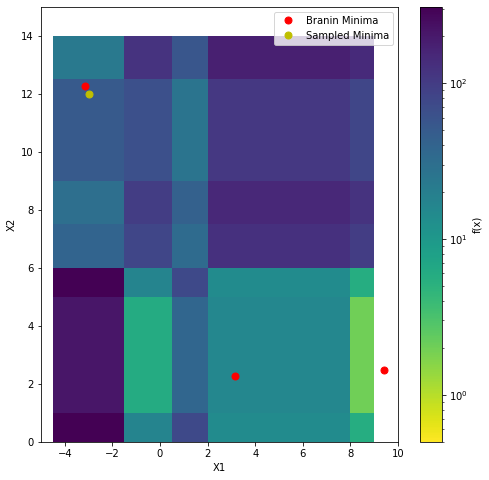

In [104]:
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt



x_ax, y_ax = np.meshgrid(X0, X1)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([branin(val) for val in vals], (shape[0], shape[0]))
fig, ax = plt.subplots(figsize=(8,8))
cm = ax.pcolormesh(x_ax, y_ax, fx,
                   norm=LogNorm(vmin=fx.min(),
                                vmax=fx.max()),
                   cmap='viridis_r')

minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
found_minima = np.reshape([x_ax[np.where(fx == np.min(fx))][0], y_ax[np.where(fx == np.min(fx))][0]], (1, 2))


ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
        lw=0, label="Branin Minima")
ax.plot(found_minima[:, 0], found_minima[:, 1], "y.", markersize=14,
        lw=0, label="Sampled Minima")

cb = fig.colorbar(cm)
cb.set_label("f(x)")

ax.legend(loc="best", numpoints=1)

ax.set_xlabel("X1")
ax.set_xlim([-5, 10])
ax.set_ylabel("X2")
ax.set_ylim([0, 15])

plt.show()

# Initialize Emulator Model

In [37]:
np.std(Y)

219770.23070982567

In [38]:
kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4)
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.optimize()


model_emukit = GPyModelWrapper(gpy_model)

# Decision Loop

In [29]:
# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

In [82]:
from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition


In [83]:
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model=model_emukit)
us_acquisition = ModelVariance(model_emukit)
ivr_acquisition = IntegratedVarianceReduction(model_emukit, parameter_space)


log_acq = LogAcquisition(expected_improvement)
optimizer = GradientAcquisitionOptimizer(space=parameter_space)


In [84]:
# Create the Bayesian optimization object
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=log_acq,
                                         batch_size=3)

In [85]:
# Run the loop and extract the optimum
# Run the loop until we either complete 10 steps or converge
stopping_condition = FixedIterationsStoppingCondition(
    i_max=10) | ConvergenceStoppingCondition(eps=0.01)

bayesopt_loop.run_loop(f, stopping_condition)


In [13]:
initial_design_samples = num_data_points
new_Y = bayesopt_loop.loop_state.Y[initial_design_samples:, :]
new_X = bayesopt_loop.loop_state.X[initial_design_samples:, :]


Note that this "sorting" of inputs only works in 1D due to flattening. 
When we move to 2D, we should not plot lines but scatters

In [86]:
new_X = bayesopt_loop.loop_state.X
order = new_X.argsort(axis=0)
new_X = new_X[order]
new_X = new_X.flatten().reshape(-1, 1)
new_Y = bayesopt_loop.loop_state.Y[order]
new_Y = new_Y.flatten().reshape(-1,1)

In [87]:
new_Y

array([[-1666825.],
       [-1666825.],
       [-1666825.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1569945.],
       [-1478760.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1435560.],
       [-1354980.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1251840.],
       [-1169385.],
       [-1052525.],
       [ -997115.]])

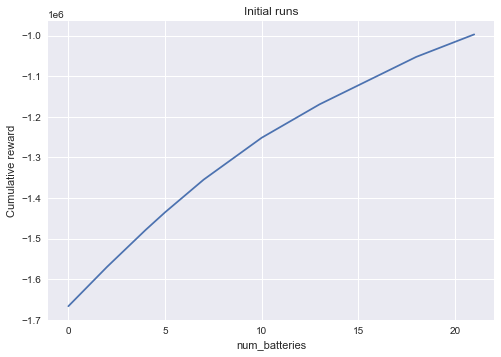

In [88]:
plt.plot(new_X, new_Y)
plt.style.use('seaborn')
plt.title("Initial runs")
plt.xlabel(parameter_space.parameters[0].name)
plt.ylabel("Cumulative reward")
plt.show()


In [71]:
x_plot = np.reshape(np.array([i for i in range(0, 25)]), (-1,1))


In [73]:
X

array([[ 7],
       [18],
       [ 0],
       [ 5]])

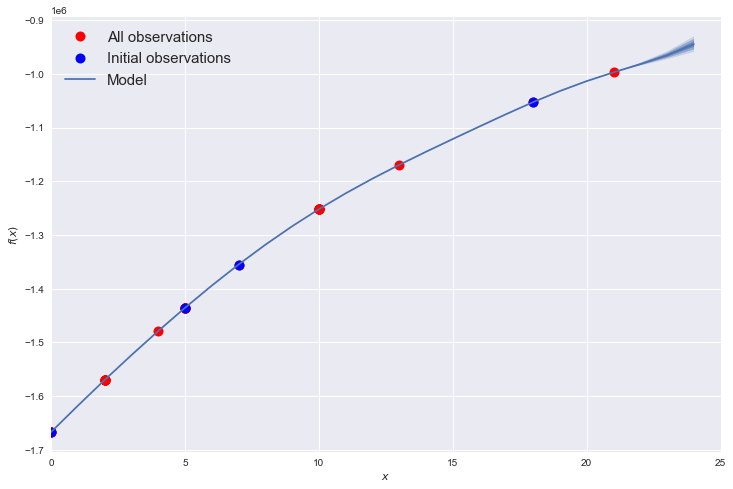

In [89]:
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 25)
plt.show()


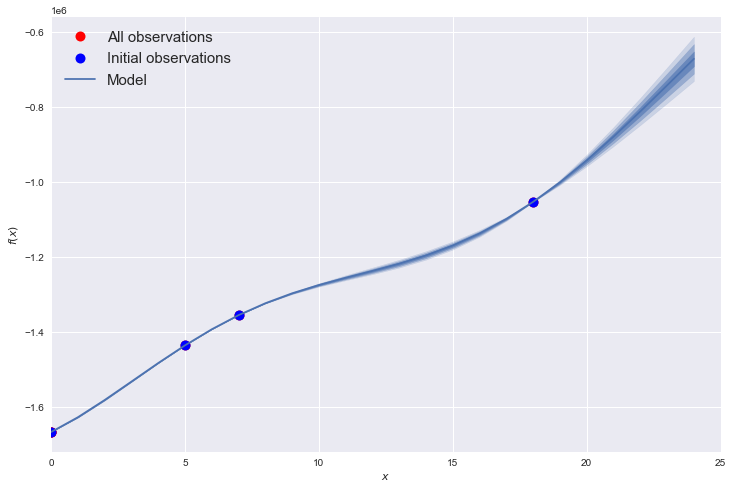

In [79]:
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 25)
plt.show()

In [76]:
us_plot = us_acquisition.evaluate(x_plot)
ivr_plot = ivr_acquisition.evaluate(x_plot)

IVR is arguably te more principled approach, but often US is preferred over IVR simply because it lends itself to gradient based optimization more easily, is cheaper to compute, and is exact. For both of them (stochastic) gradient base optimizers are used to retrieve the next datapoint

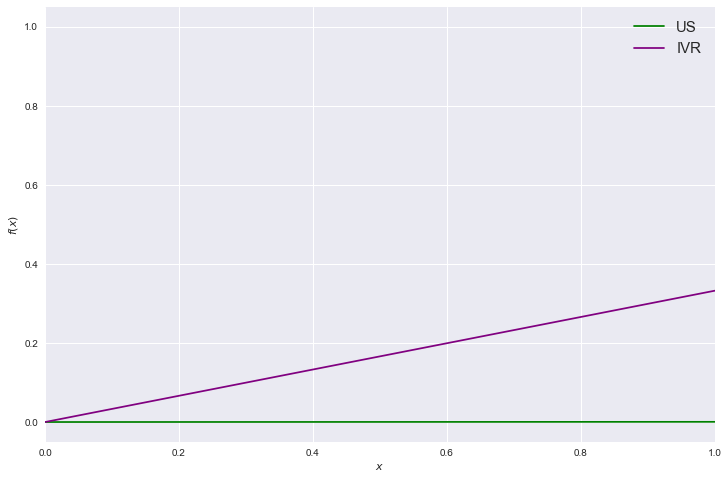

In [77]:
plt.figure(figsize=(12, 8))
plt.plot(x_plot, us_plot / np.max(us_plot), "green", label="US")
plt.plot(x_plot, ivr_plot / np.max(ivr_plot) , "purple", label="IVR")

plt.legend(loc=1, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(0, 1)
plt.show()

# Saving code for later plotting

In [ ]:
def plot_progress(loop, loop_state):
    plt.figure(figsize=FIG_SIZE)
    plt.contourf(x_1, x_2, y_reshape)
    # plt.plot(x_0_constraint, x_1_constraint, linewidth=3, color='k')
    plt.plot(loop_state.X[:-1, 0], loop_state.X[:-1, 1],
             linestyle='', marker='.', markersize=16, color='b')
    plt.plot(loop_state.X[-1, 0], loop_state.X[-1, 1],
             linestyle='', marker='.', markersize=16, color='r')
    plt.legend(['Constraint boundary', 'Previously evaluated points', 'Last evaluation'])


# Make BO loop
bo_loop = BayesianOptimizationLoop(
    space, emukit_model, ei, acquisition_optimizer=acquisition_optimizer)
# append plot_progress function to iteration end event
bo_loop.iteration_end_event.append(plot_progress)
bo_loop.run_loop(f, 10)

# Plotting 2D branin

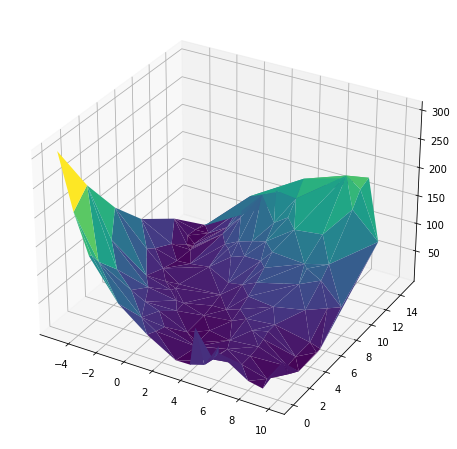

In [100]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

zline = bayesopt_loop.loop_state.Y.flatten()
xline = bayesopt_loop.loop_state.X[:, 0]
yline = bayesopt_loop.loop_state.X[:, 1]
ax.plot_trisurf(xline, yline, zline, cmap='viridis')
plt.show()

(0.0, 15.0)

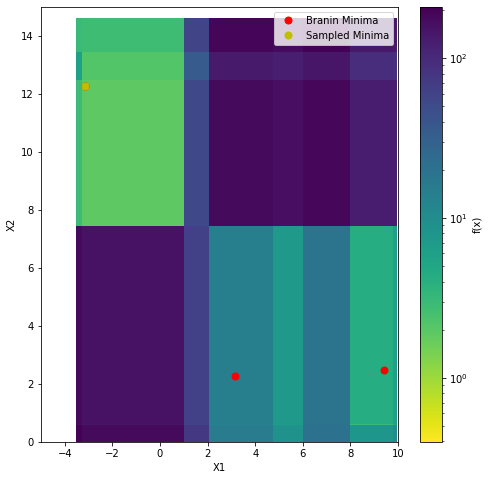

In [105]:
x_ax, y_ax = np.meshgrid(new_X[:, 0], new_X[:, 1])
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([branin(val) for val in vals], x_ax.shape)

fig, ax = plt.subplots(figsize=(8, 8))
cm = ax.pcolormesh(x_ax, y_ax, fx,
                   norm=LogNorm(vmin=fx.min(),
                                vmax=fx.max()),
                   cmap='viridis_r')

minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])

found_minima = new_X[np.where((new_Y == np.min(new_Y)))[0]]


ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
        lw=0, label="Branin Minima")
ax.plot(found_minima[:, 0], found_minima[:, 1], "y.", markersize=14,
        lw=0, label="Sampled Minima")

cb = fig.colorbar(cm)
cb.set_label("f(x)")

ax.legend(loc="best", numpoints=1)

ax.set_xlabel("X1")
ax.set_xlim([-5, 10])
ax.set_ylabel("X2")
ax.set_ylim([0, 15])
